In [19]:
from GvaDataset import GvaDataset
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms 

transform = transforms.Compose([
    transforms.Resize((1024, 512))
])

images_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Original"
labels_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/labels"
dataset = GvaDataset(images_path, labels_path, transform=transform)

total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% for training
test_size = total_size - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [20]:
from models.unet import UNet
from experiment import Experiment
from losses import dice_loss
import torch.optim as optim
import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters())
criterion = dice_loss
experiment = Experiment(model, criterion, optimizer, device)

In [21]:
experiment.train(train_loader=train_loader, epochs=30)

Epoch 1/30: 3batch [00:02,  1.04batch/s, avg_loss=0.413, loss=0.421]            


1/30 loss: 0.41306205590566


Epoch 2/30: 3batch [00:02,  1.05batch/s, avg_loss=0.318, loss=0.731]            


2/30 loss: 0.317691445350647


Epoch 3/30: 3batch [00:02,  1.05batch/s, avg_loss=0.272, loss=0.401]            


3/30 loss: 0.27231287956237793


Epoch 4/30: 3batch [00:02,  1.05batch/s, avg_loss=0.258, loss=0.393]            


4/30 loss: 0.2578726609547933


Epoch 5/30: 3batch [00:02,  1.06batch/s, avg_loss=0.254, loss=0.387]            


5/30 loss: 0.2538888057072957


Epoch 6/30: 3batch [00:02,  1.04batch/s, avg_loss=0.251, loss=0.0633]           


6/30 loss: 0.25087475776672363


Epoch 7/30: 3batch [00:02,  1.05batch/s, avg_loss=0.253, loss=0.117]            


7/30 loss: 0.2534576654434204


Epoch 8/30: 3batch [00:02,  1.06batch/s, avg_loss=0.248, loss=-.316]            


8/30 loss: 0.24842729171117148


Epoch 9/30: 3batch [00:02,  1.06batch/s, avg_loss=0.226, loss=-.103]            


9/30 loss: 0.22591731945673624


Epoch 10/30: 3batch [00:02,  1.05batch/s, avg_loss=0.206, loss=0.339]           


10/30 loss: 0.2055517633756002


Epoch 11/30: 3batch [00:02,  1.05batch/s, avg_loss=0.193, loss=0.0895]          


11/30 loss: 0.19279096523920694


Epoch 12/30: 3batch [00:02,  1.05batch/s, avg_loss=0.224, loss=-.391]           


12/30 loss: 0.22372466325759888


Epoch 13/30: 3batch [00:02,  1.06batch/s, avg_loss=0.192, loss=0.374]           


13/30 loss: 0.19240546226501465


Epoch 14/30: 3batch [00:02,  1.06batch/s, avg_loss=0.175, loss=0.263]           


14/30 loss: 0.17483258247375488


Epoch 15/30: 3batch [00:02,  1.05batch/s, avg_loss=0.192, loss=-.431]           


15/30 loss: 0.19194833437601724


Epoch 16/30: 3batch [00:02,  1.06batch/s, avg_loss=0.16, loss=0.0611]           


16/30 loss: 0.16033989191055298


Epoch 17/30: 3batch [00:02,  1.04batch/s, avg_loss=0.188, loss=0.736]           


17/30 loss: 0.18780972560246786


Epoch 18/30: 3batch [00:02,  1.05batch/s, avg_loss=0.147, loss=0.315]           


18/30 loss: 0.14686113595962524


Epoch 19/30: 3batch [00:02,  1.06batch/s, avg_loss=0.146, loss=0.00396]         


19/30 loss: 0.14585036039352417


Epoch 20/30: 3batch [00:02,  1.05batch/s, avg_loss=0.143, loss=-.222]           


20/30 loss: 0.14343388875325522


Epoch 21/30: 3batch [00:02,  1.05batch/s, avg_loss=0.151, loss=0.729]           


21/30 loss: 0.15137275060017905


Epoch 22/30: 3batch [00:02,  1.05batch/s, avg_loss=0.136, loss=0.651]           


22/30 loss: 0.1361093521118164


Epoch 23/30: 3batch [00:02,  1.05batch/s, avg_loss=0.146, loss=-.112]           


23/30 loss: 0.14594809214274088


Epoch 24/30: 3batch [00:02,  1.06batch/s, avg_loss=0.128, loss=-.377]           


24/30 loss: 0.1280487577120463


Epoch 25/30: 3batch [00:02,  1.06batch/s, avg_loss=0.135, loss=0.265]           


25/30 loss: 0.1350144942601522


Epoch 26/30: 3batch [00:02,  1.05batch/s, avg_loss=0.118, loss=-.0296]          


26/30 loss: 0.11793378988901775


Epoch 27/30: 3batch [00:02,  1.05batch/s, avg_loss=0.13, loss=-.286]            


27/30 loss: 0.12957934538523355


Epoch 28/30: 3batch [00:02,  1.05batch/s, avg_loss=0.12, loss=-.318]            


28/30 loss: 0.12008241812388103


Epoch 29/30: 3batch [00:02,  1.05batch/s, avg_loss=0.0982, loss=0.352]          


29/30 loss: 0.09821859995524089


Epoch 30/30: 3batch [00:02,  1.05batch/s, avg_loss=0.0821, loss=0.638]          

30/30 loss: 0.08208527167638142
Training Complete


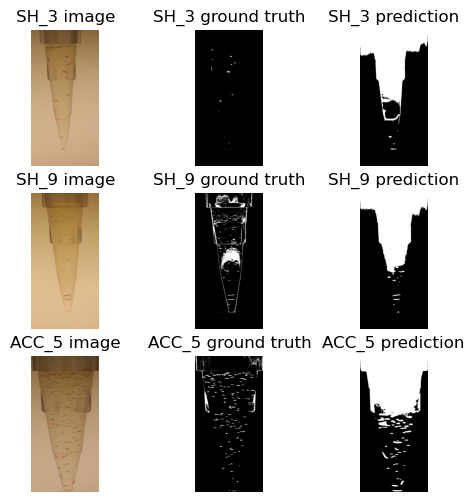

In [43]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i, data in enumerate(test_loader):
        img, label, file = data
        file = file[0]
        img = img.to(device)
        pred = model(img)
        pred = pred > 0.5
        
        img = img.to('cpu')
        img = img.squeeze()
        img = img.permute(1, 2, 0)

        label = label.squeeze()
            
        pred = pred.to('cpu')
        pred = pred.squeeze()
        
        ax[i, 0].imshow(img)
        ax[i, 0].axis('off')
        ax[i, 0].set_title(file + " image")
        ax[i, 1].imshow(label, cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(file + " ground truth")
        ax[i, 2].imshow(pred, cmap='gray')
        ax[i, 2].axis('off')
        ax[i, 2].set_title(file + " prediction")

plt.savefig('3-1-24.png')

        

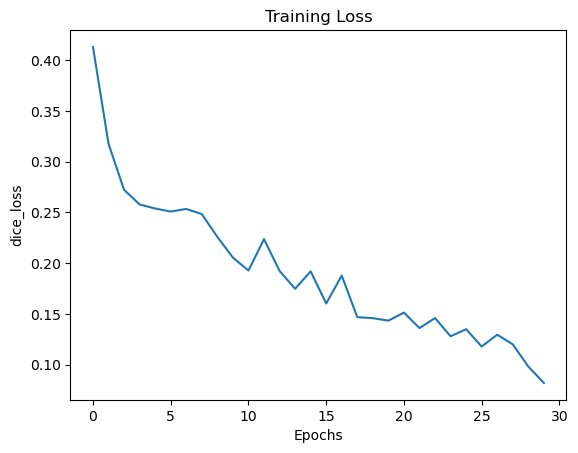

In [44]:
experiment.plot_loss()